In [13]:
import pandas as pd
import numpy as np
from scipy.signal import butter, sosfiltfilt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import zscore
from matplotlib.colors import LogNorm
import os
import pycwt as cwt
import pickle
import datetime as datetime
import operator
import string

In [14]:
FS = 4 # E4 sampling rate
FREQ_ARRAY = np.append(np.arange(23, 26, 1), np.arange(6*24, 9*24, 24)) # for morlet
PANDAS_RESAMPLE_RATE = "{:.2f}".format(1/FS)+'S' # find missing samples (datetime)

MODALITY = 'eda'

# wavelet and filter variables                    
mother = cwt.Morlet(6)
order = 2 # butter bandpass filter

FONTSIZE = 32

PANDAS_RESAMPLE_RATE

'0.25S'

In [15]:
HDRS_17_CUTOFF = 20
HDRS_24_CUTOFF = 10
RCI_HDRS_17 = 6

HDRS_variant = 'hamd_17_score'

LABEL_FOLDER_PATH = 'labels/'
SAVE_CWT_FOLDER = '/media/bayesian-posterior/sdc/sensecode_data/' + MODALITY + '/cwt_' + MODALITY + '_all_freq/'

DATA_FOLDER_PATH = '/media/bayesian-posterior/sdc/sensecode_data/' + MODALITY + '/'
DATA_FOLDER = os.fsencode(DATA_FOLDER_PATH)

In [16]:
# Filter functions
# To use: butter_bandpass_filter(signal, lowcut, highcut, fs, order=1)
# def butter_bandpass(lowcut, highcut, fs, order=5):
#         nyq = 0.5 * fs
#         low = lowcut / nyq
#         high = highcut / nyq
#         sos = butter(order, [low, high], analog=False, btype='band', output='sos')
#         return sos


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
#         sos = butter_bandpass(lowcut, highcut, fs, order=order)
        sos = butter(order, [lowcut, highcut], analog=False, btype='band', output='sos')
        y = sosfiltfilt(sos, data)
        return y

In [17]:
def plot_signal(df,
                column,
                subject, 
                tick_freq = 'W', 
                fs = FS,
                y_label = MODALITY):
    
#     tick_freq_dict = {'D':FS*60*60*24, 'W':FS*60*60*24*7}
#     t = df.index[::tick_freq_dict[tick_freq]]
    
#     fig, ax = plt.subplots(figsize=(15, 2))     
#     x = df[column]
#     ax.plot(range(len(df.index)), x)
    # plt.legend(loc=1)
    
    df = df.resample('H').mean()
    tick_freq_dict = {'D':1, 'W':24*7}
    t = df.index[::tick_freq_dict[tick_freq]]
    
    fig, ax = plt.subplots(figsize=(15, 2))     
    x = df[column]
    ax.plot(range(len(df.index)), x)
    
    ax.set_xticks(range(len(df.index))[::tick_freq_dict[tick_freq]], [xt.to_pydatetime().strftime('%Y-%m-%d') for xt in t], rotation='vertical')
    ax.set_title(subject)
    ax.set_xlabel('Date')
    ax.set_ylabel(y_label)
    plt.grid()

In [34]:
def plot_morlet(df, 
                column, 
                tick_freq, 
                subject): 
    
    resampled_df = df[column].resample('H').mean()
    cwtm = resampled_df.to_numpy().T # (len(freq_list), len(t))

    tick_freq_dict = {'D':1, 'W':24*7}
    xtick_freq = tick_freq_dict[tick_freq]

    fig, ax = plt.subplots(figsize=(30, 5)) 
    t = resampled_df.index[::tick_freq_dict[tick_freq]]
    
    # sns.set(font_scale=1.4)
    ax = sns.heatmap(cwtm,
                norm=LogNorm(vmin=cwtm.min(), vmax=cwtm.max()),
                cmap="Blues",
                ax=ax, 
                    cbar_kws={"shrink": 2})
    cax = ax.figure.axes[-1]
    cax.tick_params(labelsize=FONTSIZE)
    
    ax.text(.01, 1.2, 'C', ha='left', va='top', transform=ax.transAxes, fontsize=FONTSIZE, weight='bold')
    ax.set_xticks(range(len(resampled_df.index))[::tick_freq_dict[tick_freq]], [xt.to_pydatetime().strftime('%Y-%m-%d') for xt in t], fontsize=FONTSIZE)
    ax.set_yticks(np.arange(len(column))+0.5, column, fontsize=FONTSIZE)
    # ax.set_title(subject, y = 1.1)
    # fig.tight_layout()
    plt.savefig(subject + '_morlet.png', dpi=300)

In [35]:
def plot_raw_and_filtered_signal_together(df,
                                            columns,
                                          y_labels, 
                                            subject, 
                                            tick_freq = 'W', 
                                            fs = FS):
    
    assert len(columns) == len(y_labels)
    
    df = df.resample('H').mean()
    tick_freq_dict = {'D':1, 'W':24*7}
    t = df.index[::tick_freq_dict[tick_freq]]
    
    fig, axs = plt.subplots(len(columns), 1, figsize=(30, 5*len(columns)), sharex = True)
    # fig.suptitle(subject)
    fig.subplots_adjust(top = 0.9)
    
    subfig_labels = list(string.ascii_uppercase)
    
    for idx in range(len(columns)):
        x = df[columns[idx]]
        axs[idx].plot(range(len(df.index)), x)
        axs[idx].set_ylabel(y_labels[idx].upper(), fontsize=FONTSIZE)
        axs[idx].tick_params(axis='y', which='major', labelsize=FONTSIZE)
        axs[idx].grid()
        axs[idx].text(.01, .99, subfig_labels[idx], ha='left', va='top', transform=axs[idx].transAxes, fontsize=FONTSIZE, weight='bold')
        
        if idx == len(columns) - 1: 
            axs[idx].set_xticks(range(len(df.index))[::tick_freq_dict[tick_freq]], 
                                [xt.to_pydatetime().strftime('%Y-%m-%d') for xt in t], 
                                fontsize=FONTSIZE, 
                                rotation = 45)
            
            axs[idx].set_xlabel('Date', fontsize=FONTSIZE)
    fig.tight_layout()
    plt.savefig(subject + '_' + MODALITY + '_raw_and_bandpassed.png', dpi=300)

SP24 0.908 86


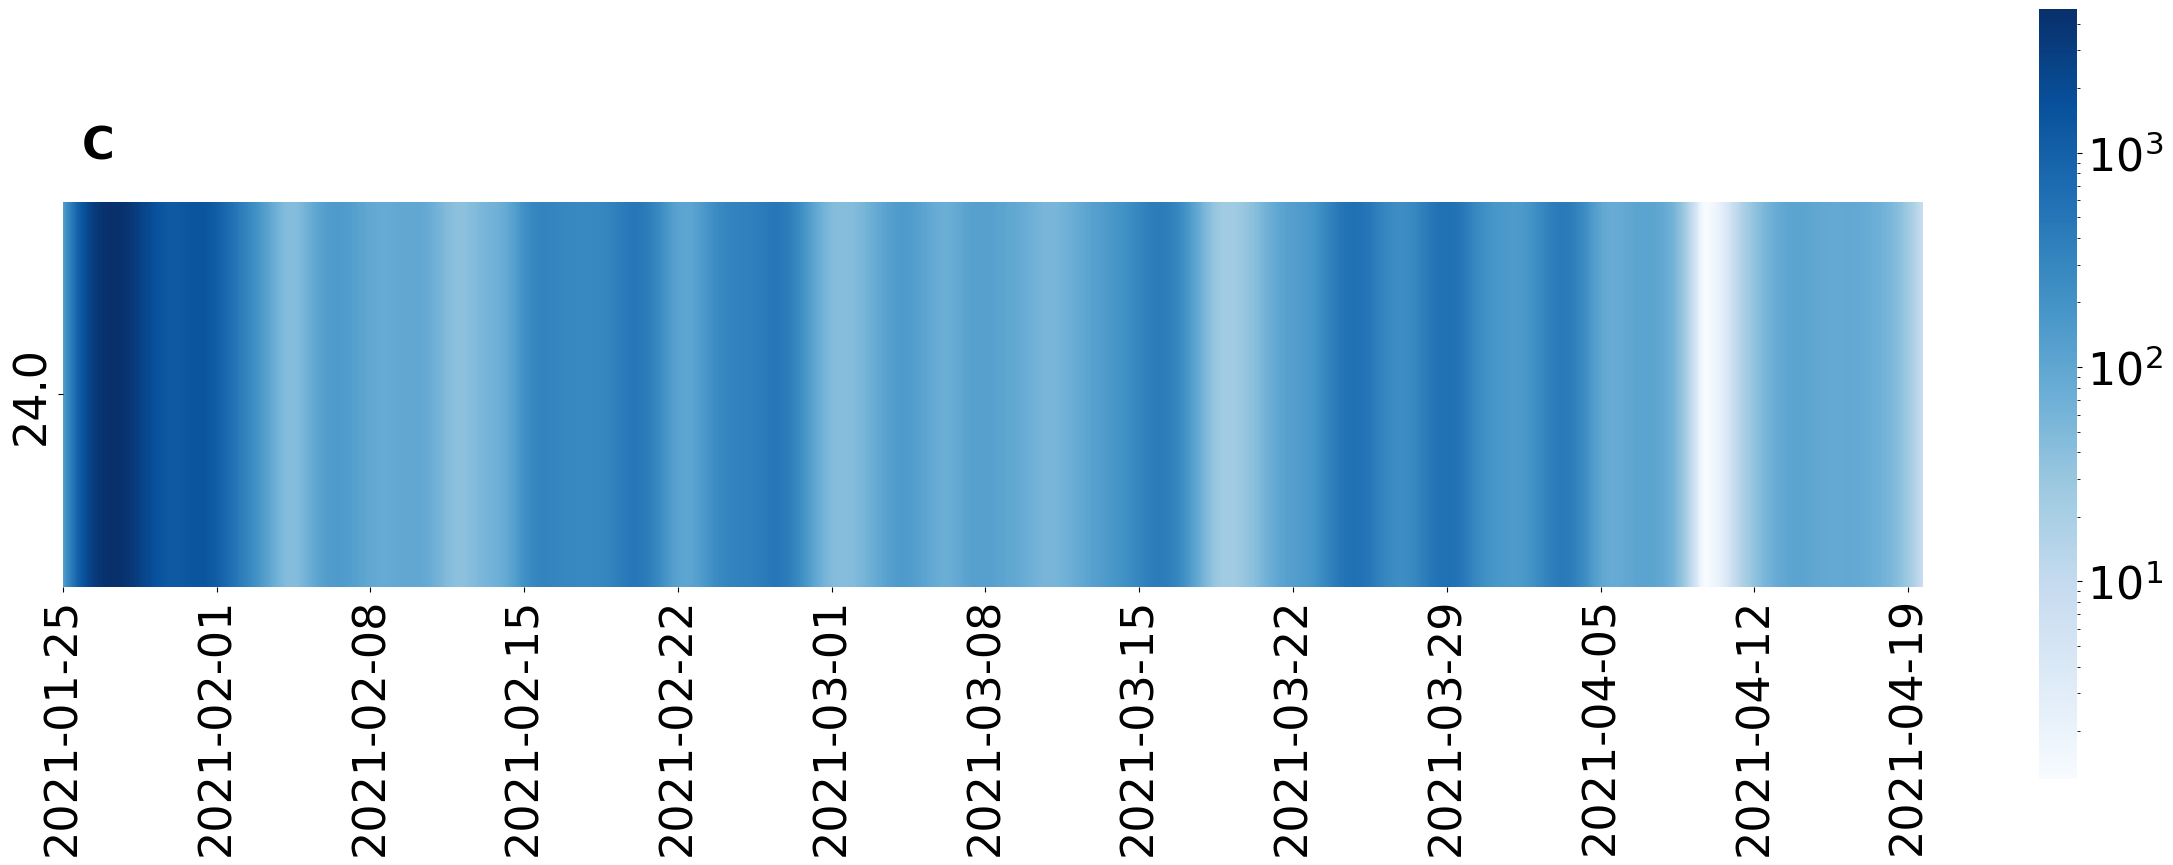

In [36]:
circadian_f = '24.0'

worn_percent_list = []
day_length_list = []


for file in os.listdir(SAVE_CWT_FOLDER):
    
    filename = os.fsdecode(file)
    
    if filename.endswith("P24_cwt.h5"):
        
        subject = filename.split('_')[0]
        eda_filepath = SAVE_CWT_FOLDER+filename
        df_cwt = pd.read_hdf(eda_filepath, 'df')        

        raw_filepath = DATA_FOLDER_PATH + subject + '_' + MODALITY + '_worn_left.h5'        
        raw_signal_df = pd.read_hdf(raw_filepath)
        worn_length = len(raw_signal_df)
        
        raw_signal_df = raw_signal_df.resample(PANDAS_RESAMPLE_RATE).mean() # NaN for missing data
        resampled_length = len(raw_signal_df)
        
        worn_percent = worn_length / resampled_length
        worn_percent_list.append(worn_percent)
        
        day_length = len(raw_signal_df.resample('D').mean())
        day_length_list.append(day_length)
    
        print(subject, "{:.3f}".format(worn_percent), day_length)
        

        cwt_filepath = SAVE_CWT_FOLDER + subject + '_cwt.h5'
        df_cwt = pd.read_hdf(cwt_filepath)

        plot_morlet(df_cwt, 
                    column = [circadian_f], 
                    tick_freq = 'W', 
                    subject = subject)

        # raw_signal_df['interpolated_' + MODALITY] = raw_signal_df.fillna(raw_signal_df[MODALITY].median())
#         raw_signal_df['interpolated_' + MODALITY] = raw_signal_df.interpolate()
#         circadian_freq = float(circadian_f)
#         raw_signal_df['bandpass_' + circadian_f] = butter_bandpass_filter(raw_signal_df['interpolated_' + MODALITY], 
#                                                                            lowcut = 1/((circadian_freq + (1/3)*circadian_freq) * 60 * 60), 
#                                                                            highcut = 1/((circadian_freq - (1/3)*circadian_freq) * 60 * 60), 
#                                                                            fs = FS, 
#                                                                            order=order)

#         plot_raw_and_filtered_signal_together(df = raw_signal_df,
#                                                 columns = ['interpolated_' + MODALITY, 'bandpass_' + circadian_f],
#                                                 y_labels = [MODALITY, 'bandpass_' + circadian_f], 
#                                                 subject = subject, 
#                                                 tick_freq = 'W', 
#                                                 fs = FS)


In [9]:
# n, bins, patches = plt.hist(worn_percent_list, 25, alpha=0.75)


# plt.xlabel('% of Time E4 was Worn')
# plt.ylabel('# of Patients')
# plt.grid(True)
# plt.show()

In [10]:
# n, bins, patches = plt.hist(day_length_list, 25, alpha=0.75)


# plt.xlabel('% of Days Participated')
# plt.ylabel('# of Patients')
# plt.grid(True)
# plt.show()

In [11]:
# print(np.mean(worn_percent_list), np.std(worn_percent_list))

# print(np.mean(day_length_list), np.std(day_length_list))

In [12]:
# 0.7080590467278376 0.14833892196950252
# 83.91428571428571 5.352550412501254